TP - 2023 - ACP and NMF on Images
March 27, 2023

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
%matplotlib inline

1. Eigenvalues methods for feature extraction (PCA and NMF)

1.1 PCA

An application of PCA is feature extraction. The idea behind feature extraction is that it is possible to find a representation of your data that is better suited to analysis than the raw representation you were given. A great example of an application where feature extraction is helpful is with images. Images are made up of pixels, usually stored as red, green, and blue (RGB) intensities. Objects in images are usually made up of thousands of pixels, and only together are they meaningful.
We will give a very simple application of feature extraction on images using PCA, by working with face images from the Labeled Faces in the Wild dataset. This dataset contains face images of celebrities downloaded from the Internet, and it includes faces of politicians, singers, actors, and athletes from the early 2000s.
We use grayscale of these images, and scale them down for faster processing.

In [4]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape
print("image_shape: {}".format(image_shape))

image_shape: (87, 65)


fix, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (),␣ ↪'yticks': ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()): ax.imshow(image, cmap='gray') ax.set_title(people.target_names[target])

There are 3,023 images, each 87×65 pixels large, belonging to 62 different people

In [5]:
print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}".format(len((people.target_names))))

people.images.shape: (3023, 87, 65)
Number of classes: 62


The data set is a bit skewed, however, containing a lot of images of George W. Bush and Colin Powell, as you can see here:

In [6]:
# count how often each target appears
counts = np.bincount(people.target)
# print counts next to target names
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end=' ')
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39 Alvaro Uribe               35 Amelie Mauresmo            21 
Andre Agassi               36 Angelina Jolie             20 Ariel Sharon               77 
Arnold Schwarzenegger      42 Atal Bihari Vajpayee       24 Bill Clinton               29 
Carlos Menem               21 Colin Powell              236 David Beckham              31 
Donald Rumsfeld           121 George Robertson           22 George W Bush             530 
Gerhard Schroeder         109 Gloria Macapagal Arroyo    44 Gray Davis                 26 
Guillermo Coria            30 Hamid Karzai               22 Hans Blix                  39 
Hugo Chavez                71 Igor Ivanov                20 Jack Straw                 28 
Jacques Chirac             52 Jean Chretien              55 Jennifer Aniston           21 
Jennifer Capriati          42 Jennifer Lopez             21 Jeremy Greenstock          24 
Jiang Zemin                20 John Ashcroft              53 John Negroponte            31 

To make the data less skewed, we will only take up to 50 images of each person (otherwise, the feature extraction would be overwhelmed by the likelihood of George W. Bush):

In [8]:
mask = np.zeros(people.target.shape, dtype=bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
X_people = people.data[mask]
y_people = people.target[mask]
# scale the grayscale values to be between 0 and 1 # instead of 0 and 255 for better numeric stability X_people = X_people / 255.

A common task in face recognition is to ask if a previously unseen face belongs to a known person from a database. This has applications in photo collection, social media, and security applications. One way to solve this problem would be to build a classifier where each person is a separate class. However, there are usually many different people in face databases, and very few images of the same person (i.e., very few training examples per class). That makes it hard to train most classifiers. Additionally, you often want to be able to add new people easily, without needing to retrain a large model.
A simple solution is to use a one-nearest-neighbor classifier that looks for the most similar face image to the face you are classifying. This classifier could in principle work with only a single training example per class. Let’s take a look at how well KNeighborsClassifier does here:

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0) # build a KNeighborsClassifier using one neighbor
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print("Test set score of 1-nn: {:.2f}".format(knn.score(X_test, y_test)))

Test set score of 1-nn: 0.14


We obtain an accuracy of 26.6%, which is not actually that bad for a 62-class classification problem (random guessing would give you around 1/62 = 1.5% accuracy), but is also not great. We only correctly identify a person every fourth time.
This is where PCA comes in. Computing distances in the original pixel space is quite a bad way to measure similarity between faces. When using a pixel representation to compare two images, we compare the grayscale value of each individual pixel to the value of the pixel in the corresponding position in the other image. This representation is quite different from how humans would interpret the image of a face, and it is hard to capture the facial features using this raw representation. For example, using pixel distances means that shifting a face by one pixel to the right corresponds to a drastic change, with a completely different representation. We hope that using distances along principal components can improve our accuracy. Here, we enable the whitening option of PCA, which rescales the principal components to have the same scale. This is the same as using StandardScaler after the transformation.
We fit the PCA object to the training data and extract the first 100 principal components. Then we transform the training and test data:

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("X_train_pca.shape: {}".format(X_train_pca.shape))

X_train_pca.shape: (1547, 100)


In [11]:
X_train_pca

array([[-0.92986315, -0.6286399 , -0.05129887, ..., -1.6577691 ,
        -0.7476229 ,  0.40710005],
       [ 0.00641363,  0.0848633 ,  1.9895275 , ..., -0.6708064 ,
        -0.8213959 ,  0.54661673],
       [ 0.18213677, -0.39802623, -1.5427966 , ...,  1.0345562 ,
        -0.10320821, -1.2449284 ],
       ...,
       [ 1.024711  ,  1.2822248 ,  1.0345123 , ...,  0.524362  ,
        -0.71594644,  0.16748993],
       [-0.45031825,  0.22305879,  0.11013259, ..., -0.89496017,
        -0.67580944,  1.7486342 ],
       [ 0.41719773,  2.366722  , -1.0872265 , ...,  1.2500622 ,
        -0.2322015 ,  0.21863092]], dtype=float32)

The new data has 100 features, the first 100 principal components. Now, we can use the new representation to classify our images using a one-nearest-neighbors classifier:

In [12]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)
print("Test set accuracy: {:.2f}".format(knn.score(X_test_pca, y_test)))

Test set accuracy: 0.15


Our accuracy improved quite significantly, from 26.6% to 35.7%, confirming our intuition that the principal components might provide a better representation of the data.
For image data, we can also easily visualize the principal components that are found. Remember that components correspond to directions in the input space. The input space here is 50×37-pixel grayscale images, so directions within this space are also 50×37-pixel grayscale images.
Let’s look at the first couple of principal components

In [13]:
print("pca.components_.shape: {}".format(pca.components_.shape))

pca.components_.shape: (100, 5655)


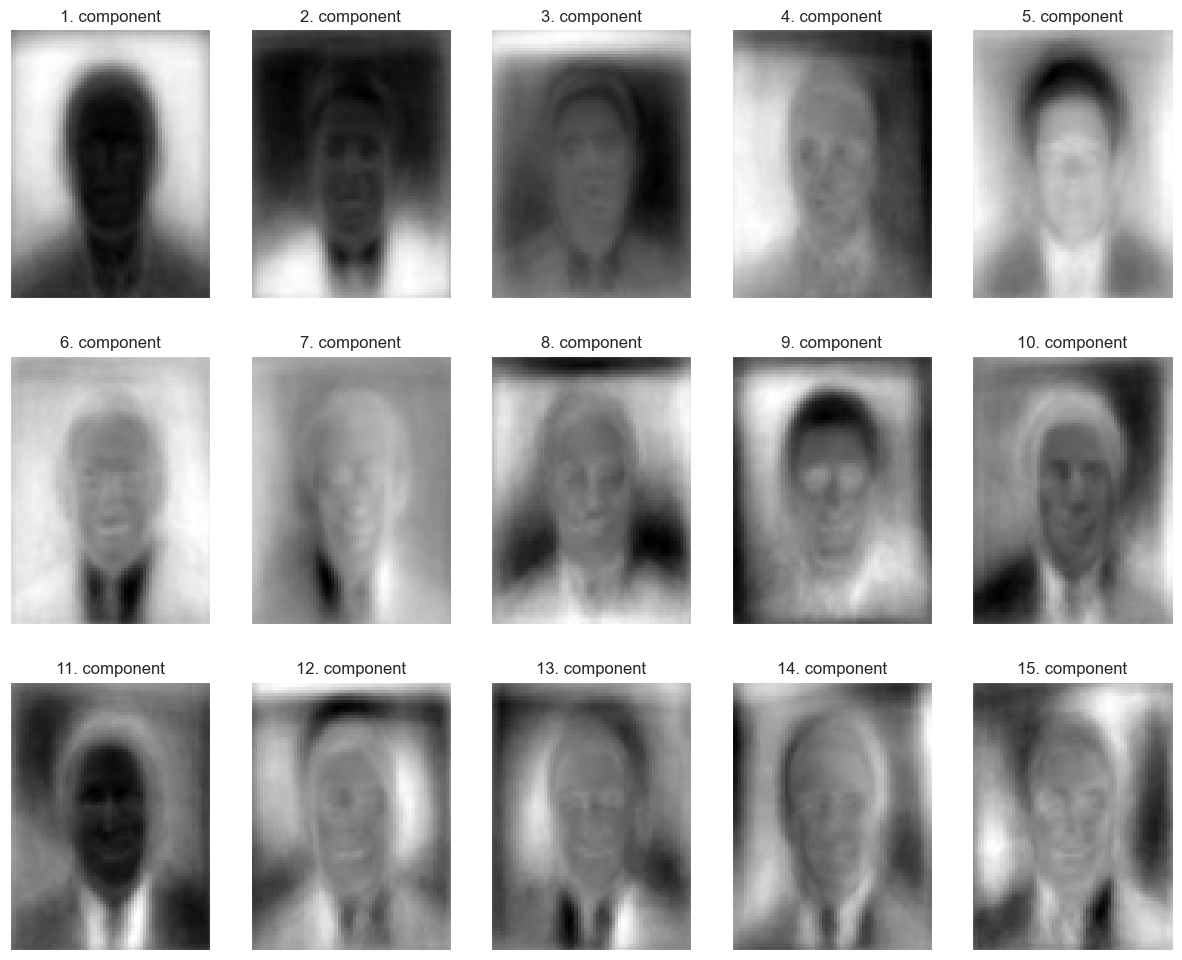

In [14]:
fix, axes = plt.subplots(3, 5, figsize=(15, 12), subplot_kw={'xticks': (),'yticks': ()})
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape), cmap='gray')
    ax.set_title("{}. component".format((i + 1)))

While we certainly cannot understand all aspects of these components, we can guess which aspects of the face images some of the components are capturing. The first component seems to mostly encode the contrast between the face and the background, the second component encodes differences in lighting between the right and the left half of the face, and so on. While this representation is slightly more semantic than the raw pixel values, it is still quite far from how a human might perceive a face. As the PCA model is based on pixels, the alignment of the face (the position of eyes, chin, and nose) and the lighting both have a strong influence on how similar two images are in their pixel representation. But alignment and lighting are probably not what a human would perceive first. When asking people to rate similarity of faces, they are more likely to use attributes like age, gender, facial expression, and hair style, which are attributes that are hard to infer from the pixel intensities. It’s important to keep in mind that algorithms often interpret data (particularly visual data, such as images, which humans are very familiar with) quite differently from how a human would.
Let’s come back to the specific case of PCA, though. We introduced the PCA transformation as rotating the data and then dropping the components with low variance. Another useful interpre- tation is to try to find some numbers (the new feature values after the PCA rotation) so that we can express the test points as a weighted sum of the principal components
X = x1 * C1 + x2 * C2 + ...
Here, 𝑥0, 𝑥1, and so on are the coeﬀicients of the principal components for this data point; in other
words, they are the representation of the image in the rotated space.
Another way we can try to understand what a PCA model is doing is by looking at the reconstruc- tions of the original data using only some components. We can do a transformation for the faces by reducing the data to only some principal components and then rotating back into the original space. This return to the original feature space can be done using the inverse_transform method. Here, we visualize the reconstruction of some faces using 10, 50, 100, 500, or 2,000 components

In [15]:
def pca_faces(X_train, X_test):
    # Build NMF models with 10, 50, 100, 500 components
    # this list will hold the back-transformd test-data
    reduced_images = []
    for n_components in [10, 50, 100, 500]:
        # build the NMF model
        pca = PCA(n_components=n_components)
        pca.fit(X_train)
        # transform the test data (afterwards has n_components many dimensions)
        X_test_pca = pca.transform(X_test)
        # back-transform the transformed test-data
        # (afterwards it's in the original space again)
        X_test_back = pca.inverse_transform(X_test_pca)
        reduced_images.append(X_test_back)
    return reduced_images

def plot_pca_faces(X_train, X_test, image_shape):
    reduced_images = pca_faces(X_train, X_test)  # pca_faces function is not defined in the code
    # plot the first three images in the test set:
    fig, axes = plt.subplots(3, 5, figsize=(15, 12), subplot_kw={'xticks': (), 'yticks': ()})
    for i, ax in enumerate(axes): # plot original image
        ax[0].imshow(X_test[i].reshape(image_shape), vmin=0, vmax=1, cmap='gray')
        #plot the four back-transformed images
        for a, X_test_back in zip(ax[1:], reduced_images):
            a.imshow(X_test_back[i].reshape(image_shape), vmin=0, vmax=1,cmap='gray') #label the top row
    axes[0, 0].set_title("original image")
    for ax, n_components in zip(axes[0, 1:], [10, 50, 100, 500]):
        ax.set_title("%d components" % n_components)

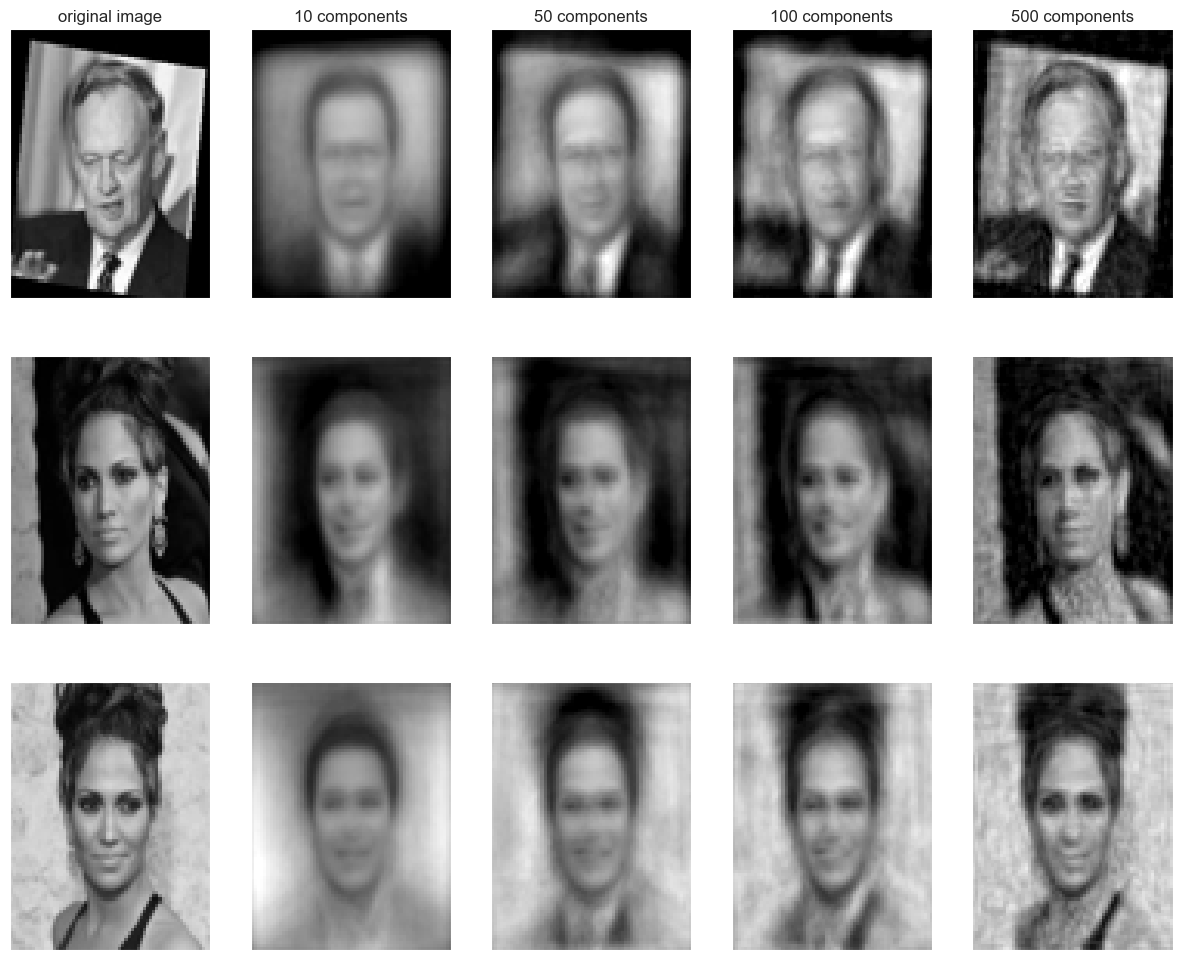

In [16]:
plot_pca_faces(X_train, X_test, image_shape)

You can see that when we use only the first 10 principal components, only the essence of the picture, like the face orientation and lighting, is captured. By using more and more principal components, more and more details in the image are preserved. This corresponds to extending the sum in the previous figure to include more and more terms. Using as many components as there are pixels would mean that we would not discard any information after the rotation, and we would reconstruct the image perfectly.
We can also try to use PCA to visualize all the faces in the dataset in a scatter plot using the first two principal components, with classes given by who is shown in the image, similarly to what we did for the cancer dataset:

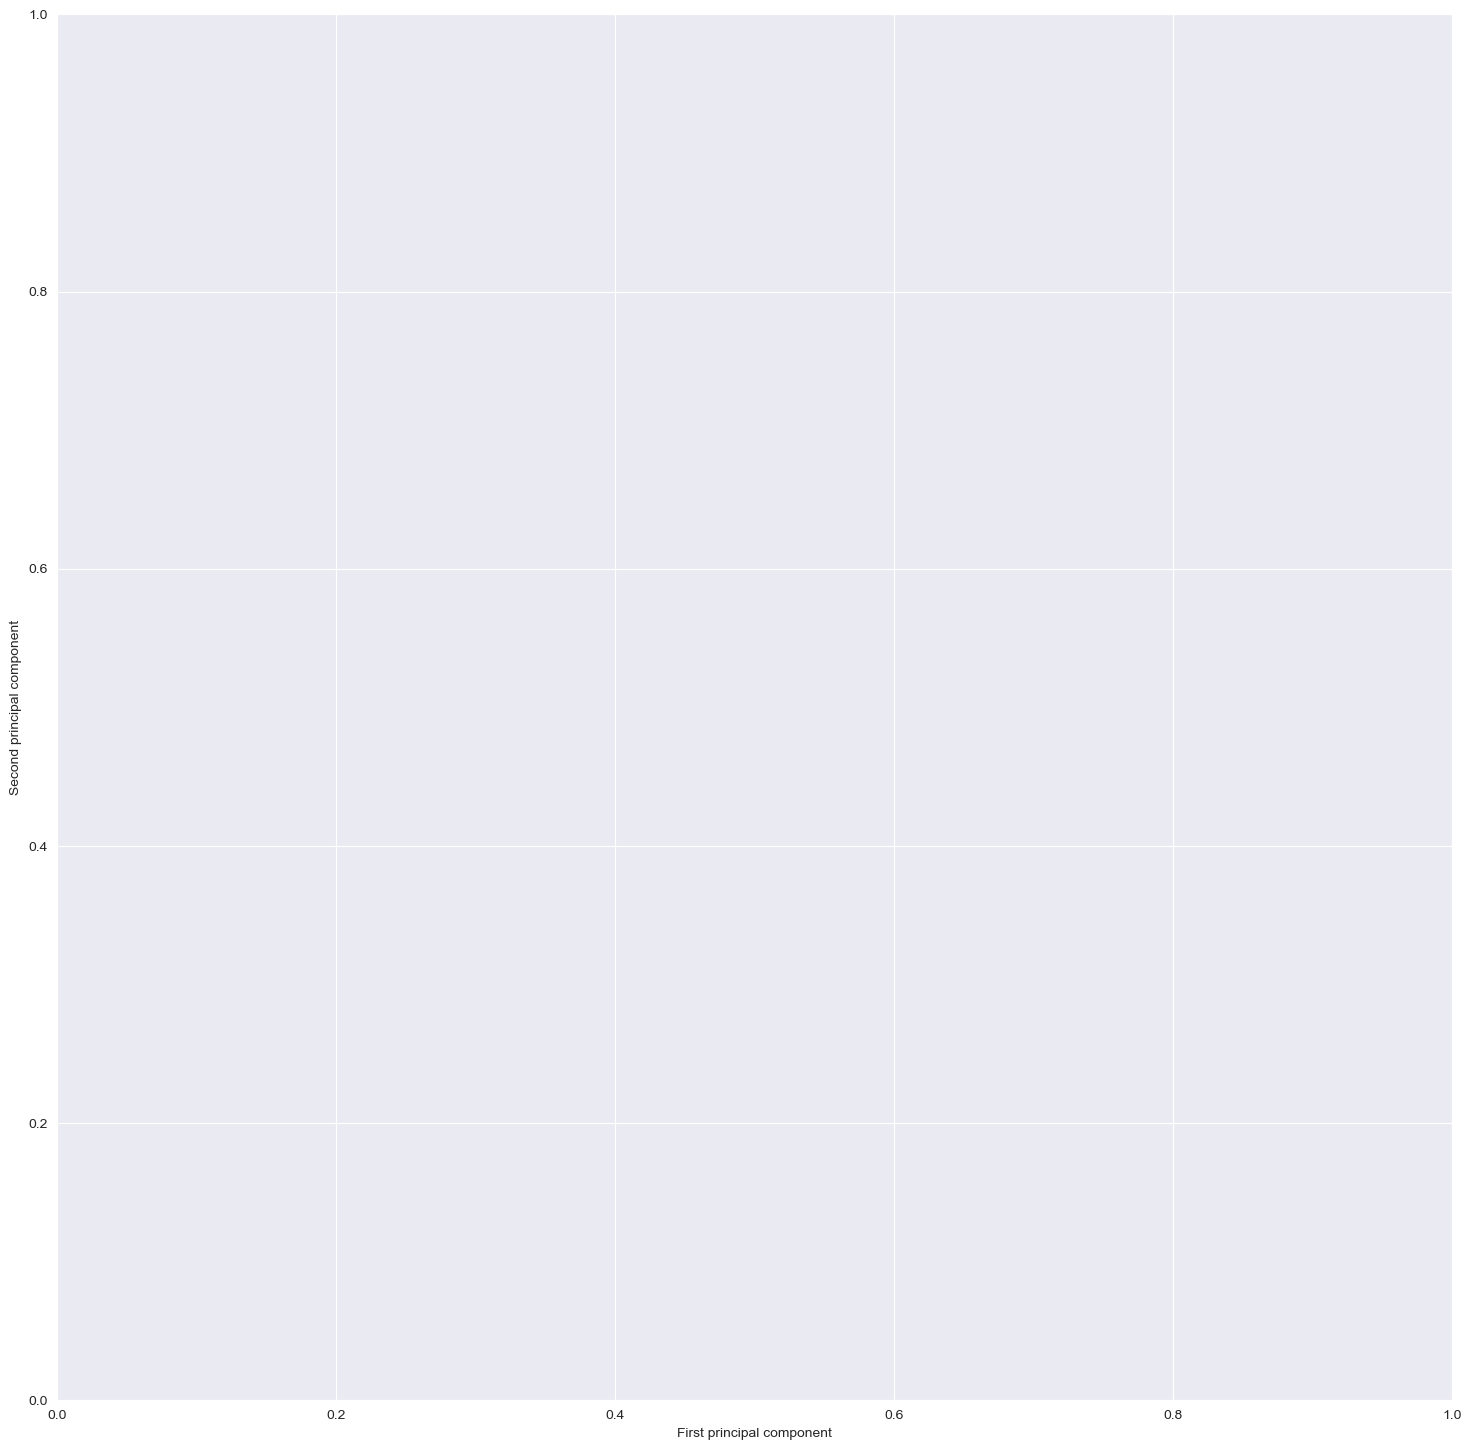

In [26]:
#import plot_scatter as ps

fig, ax = plt.subplots(1, 1, figsize=(18, 18))
#ps.plot_scatter(X_train_pca, y_train, ax=ax)
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

As yo can see, when we use only the first two principal components the whole data is just a big blob, with no separation of classes visible. This is not very surprising, given that even with 10 components, as shown earlier, PCA only captures very rough characteristics of the faces.

1.2 Non-Negative Matrix Factorization (NMF)

Non-negative matrix factorization is another unsupervised learning algorithm that aims to extract useful features. It works similarly to PCA and can also be used for dimensionality reduction. As in PCA, we are trying to write each data point as a weighted sum of some components. But whereas in PCA we wanted components that were orthogonal and that explained as much variance of the data as possible, in NMF, we want the components and the coeﬀicients to be non-negative; that is, we want both the components and the coeﬀicients to be greater than or equal to zero. Consequently, this method can only be applied to data where each feature is non-negative, as a non-negative sum of non-negative components cannot become negative.
The process of decomposing data into a non-negative weighted sum is particularly helpful for data that is created as the addition (or overlay) of several independent sources, such as an audio track of multiple people speaking, or music with many instruments. In these situations, NMF can identify the original components that make up the combined data. Overall, NMF leads to more interpretable components than PCA, as negative components and coeﬀicients can lead to hard- to-interpret cancellation effects. The eigenfaces in the previous figure, for example, contain both positive and negative parts, and as we mentioned in the description of PCA, the sign is actually arbitrary.

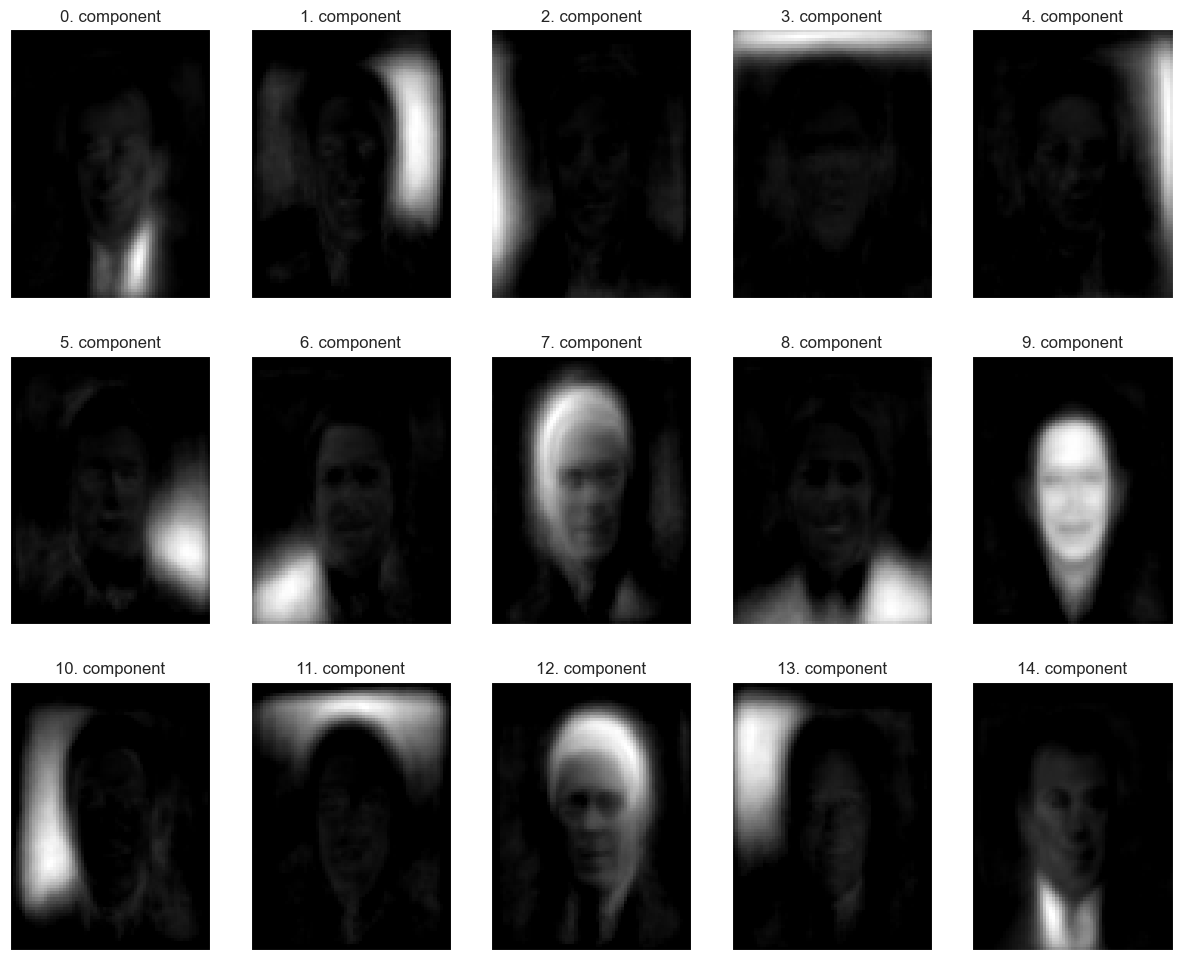

In [18]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=15, random_state=0, max_iter=2000)
nmf.fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)
fix, axes = plt.subplots(3, 5, figsize=(15, 12), subplot_kw={'xticks': (),'yticks': ()})
for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape), cmap='gray')
    ax.set_title("{}. component".format(i))

These components are all positive, and so resemble prototypes of faces much more so than the components shown for PCA. For example, one can clearly see that component 11 shows a face rotated somewhat to the right, while component 7 shows a face somewhat rotated to the left. Let’s look at the images for which these components are particularly strong

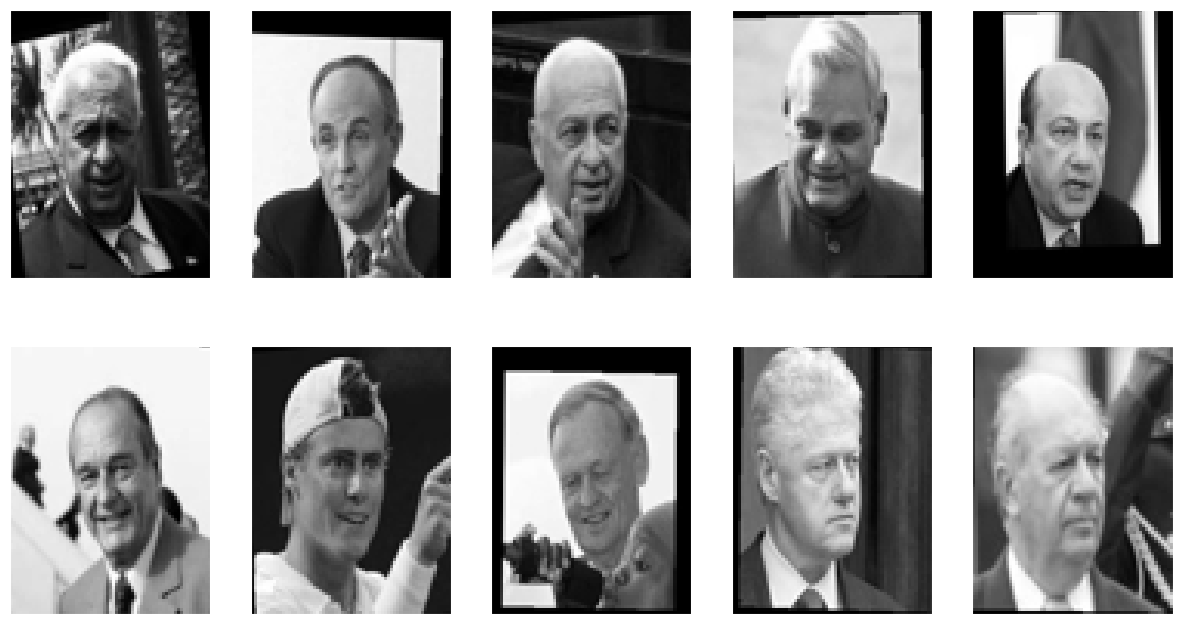

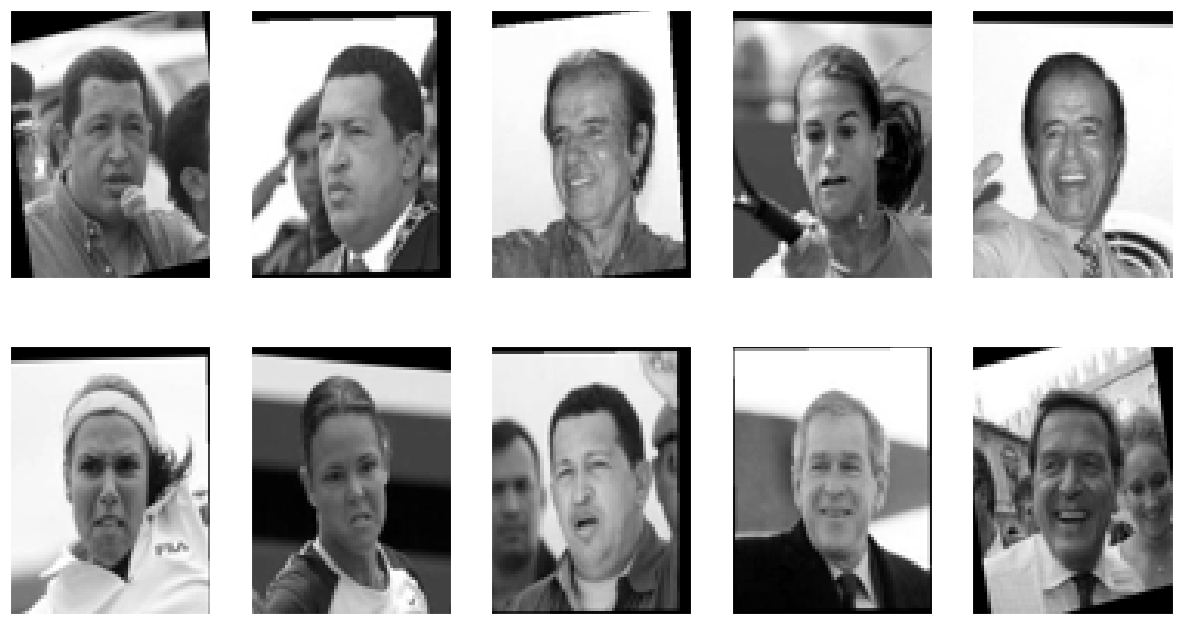

In [19]:
compn = 7
# sort by 7th component, plot first 10 images
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (),'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape), cmap='gray')
compn = 11
# sort by 11th component, plot first 10 images
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (), 'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape), cmap='gray')

As expected, faces that have a high coeﬀicient for component 11 are faces looking to the right, while faces with a high coeﬀicient for component 7 are looking to the left. As mentioned earlier, extracting patterns like these works best for data with additive structure, including audio, gene expression, and text data.
Exercise :
1. Build images using the components of the NMF
2. Apply the kNN classifier using the components of the NMF and compare the results